# Setup

In [1]:
ls

datalab/  drive/


In [2]:
#Giving colab permission to access drive

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

#Note: if you get an error :  “apt-key output should not be parsed (stdout is not a terminal)” Warning
# it means that permission has been already granted

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
#Mount drive
!mkdir -p drive
!google-drive-ocamlfuse drive

In [4]:
ls

datalab/  drive/


In [0]:
import os
os.chdir("drive/root/BTP/MassSegmentation")

In [8]:
ls

MassDicommask.bz2  MassDicomX.bz2  MassSegmentaionUnet.ipynb


# Imports

In [9]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#pytorch
!pip3 install -q http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl 
!pip3 install -q torchvision
import torch
print("pytorch version: ", torch.__version__)

pytorch version:  0.4.0


In [0]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from torch.utils.data import DataLoader 
import torch.nn.functional as F

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Data

In [0]:
import pickle
import bz2

def save(name, to_save):
    sfile = bz2.BZ2File(name, 'w')
    pickle.dump(to_save, sfile)
    sfile.close()

def load(name):
    sfile = bz2.BZ2File(name, 'rb')
    data = pickle.load(sfile)
    sfile.close()
    return data

In [0]:
X = load("MassDicomX.bz2")
mask = load("MassDicommask.bz2")

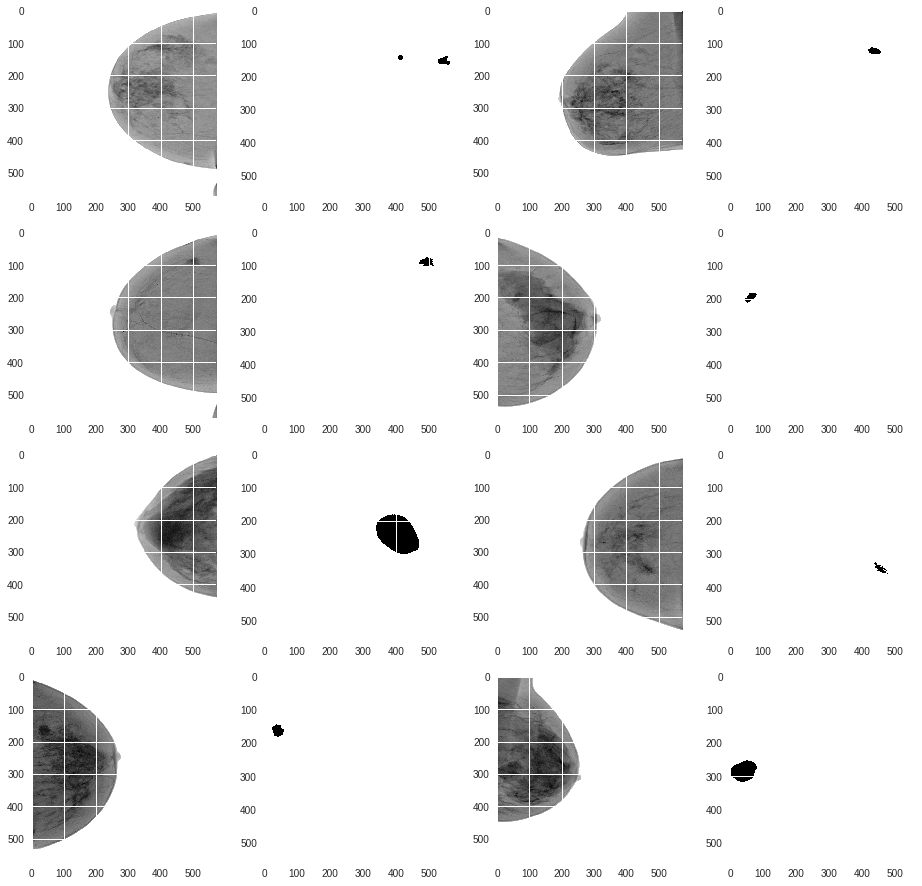

In [14]:
fig=plt.figure(figsize=(16, 32))
columns = 4
rows = 8
z =0
for i in range(1, int(columns*rows/2)+1):
    if i%2==0:
        imgp = mask[i-2][0]
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgp)
    else:
        imgp = X[i-1][0]
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgp)
plt.show()

In [15]:
from sklearn.cross_validation import train_test_split
X_train, X_test, mask_train, mask_test = train_test_split(X, mask, test_size = 0.15, random_state = 7)

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [0]:
X_train_t = torch.FloatTensor(X_train).to(device)
mask_train_t = torch.Tensor(mask_train).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)
mask_test_t = torch.Tensor(mask_test).to(device)

In [17]:
print(X_train_t.size())
print(mask_train_t.size())
print(X_test_t.size())
print(mask_test_t.size())

torch.Size([90, 1, 572, 572])
torch.Size([90, 1, 560, 560])
torch.Size([17, 1, 572, 572])
torch.Size([17, 1, 560, 560])


# Model 

In [0]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

In [0]:
class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

In [0]:
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

In [0]:
class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [0]:
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        return x

In [0]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

# Model Init


In [0]:
num_epochs = 10
num_classes = 1
batch_size = 1
learning_rate = 0.01
img_channel, img_height, img_width = X_train.shape[1:]

In [0]:
model = UNet(img_channel, num_classes).to(device)

In [26]:
model(X_train_t[0:batch_size]).size()

torch.Size([1, 1, 560, 560])

# Train


In [0]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [45]:
num_epochs = 25

for epoch in range(1, num_epochs+1):
    
    epoch_loss = 0
    print("\nEpoch = ", epoch)
    z = 0
        
    for i in range(len(X_train)//batch_size):
        if i == (len(X_train)//batch_size) - 1:
            x = X_train_t[z:, :, :, :]
            y = mask_train_t[z:, :, :, :]
        else:
            x = X_train_t[z:z+batch_size, :, :, :]
            y = mask_train_t[z:z+batch_size, :, :, :]
            z += batch_size

        #Forward pass
        #print(x.size())
        output = model(x)
        #print(output.size())
        loss = criterion(input = output.view(-1), target = y.view(-1))
        
        #Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if i%1 == 0:
            print( '\rStep [{}/{}], Loss: {:.4f}'.format(i+1, len(X_train)//batch_size, epoch_loss/(i+1)), end = " ")
            


Epoch =  1
Step [90/90], Loss: -64.4211 
Epoch =  2
Step [90/90], Loss: -64.8930 
Epoch =  3
Step [90/90], Loss: -64.5088 
Epoch =  4
Step [90/90], Loss: -64.1783 
Epoch =  5
Step [90/90], Loss: -64.8353 
Epoch =  6
Step [90/90], Loss: -65.1037 
Epoch =  7
Step [90/90], Loss: -65.3875 
Epoch =  8
Step [90/90], Loss: -65.5588 
Epoch =  9
Step [90/90], Loss: -65.4998 
Epoch =  10
Step [90/90], Loss: -65.5680 
Epoch =  11
Step [90/90], Loss: -65.4977 
Epoch =  12
Step [90/90], Loss: -65.9708 
Epoch =  13
Step [90/90], Loss: -65.8820 
Epoch =  14
Step [90/90], Loss: -65.8555 
Epoch =  15
Step [90/90], Loss: -65.8639 
Epoch =  16
Step [90/90], Loss: -65.9966 
Epoch =  17
Step [90/90], Loss: -66.0803 
Epoch =  18
Step [90/90], Loss: -66.4483 
Epoch =  19
Step [90/90], Loss: -66.7352 
Epoch =  20
Step [90/90], Loss: -66.0975 
Epoch =  21
Step [90/90], Loss: -66.4373 
Epoch =  22
Step [90/90], Loss: -66.3246 
Epoch =  23
Step [90/90], Loss: -66.2989 
Epoch =  24
Step [90/90], Loss: -66.0804 


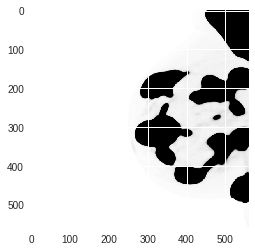

In [46]:
plt.imshow(model(X_test_t[0:1]).cpu().detach().numpy()[0][0])